<a href="https://colab.research.google.com/github/jasonh14/bert_roberta_financial_sentiment_analysis/blob/main/aol_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.1 MB/s eta 0:00:00


In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.5 MB/s eta 0:00:00


In [4]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import demoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<ipython-input-4-fdfd43664146>:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [5]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [7]:
data = pd.read_csv("data.csv")

In [8]:
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [10]:
data.drop_duplicates(subset='Sentence',inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5322 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5322 non-null   object
 1   Sentiment  5322 non-null   object
dtypes: object(2)
memory usage: 124.7+ KB


In [12]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
  return demoji.replace(text, '') #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2


#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [13]:
texts_new = []
for t in data.Sentence:
  texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [14]:
texts_new

['the geosolutions technology will leverage benefon s gps solutions by providing location based search technology a communities platform location relevant multimedia content and a new and powerful commercial model',
 'esi on lows down 150 to 250 bk a real possibility',
 'for the last quarter of 2010 componenta s net sales doubled to eur131m from eur76m for the same period a year earlier while it moved to a zero pretax profit from a pretax loss of eur7m',
 'according to the finnishrussian chamber of commerce all the major construction companies of finland are operating in russia',
 'the swedish buyout firm has sold its remaining 224 percent stake almost eighteen months after taking the company public in finland',
 'spy wouldnt be surprised to see a green close',
 'shells 70 billion bg deal meets shareholder skepticism',
 'ssh communications security corp stock exchange release october 14 2008 at 245 pm the company updates its full year outlook and estimates its results to remain at loss

In [15]:
data["Sentence_clean"] = texts_new

In [16]:
data.head()

,Sentence,Sentiment,Sentence_clean
0,The GeoSolutions technology will leverage Bene...,positive,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi on lows down 150 to 250 bk a real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,for the last quarter of 2010 componenta s net ...
3,According to the Finnish-Russian Chamber of Co...,neutral,according to the finnishrussian chamber of com...
4,The Swedish buyout firm has sold its remaining...,neutral,the swedish buyout firm has sold its remaining...


In [17]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [18]:
token_lens = []

for txt in data['Sentence_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [19]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 110


In [20]:
for txt in data['Sentence_clean'].values:
  print(txt)

the geosolutions technology will leverage benefon s gps solutions by providing location based search technology a communities platform location relevant multimedia content and a new and powerful commercial model
esi on lows down 150 to 250 bk a real possibility
for the last quarter of 2010 componenta s net sales doubled to eur131m from eur76m for the same period a year earlier while it moved to a zero pretax profit from a pretax loss of eur7m
according to the finnishrussian chamber of commerce all the major construction companies of finland are operating in russia
the swedish buyout firm has sold its remaining 224 percent stake almost eighteen months after taking the company public in finland
spy wouldnt be surprised to see a green close
shells 70 billion bg deal meets shareholder skepticism
ssh communications security corp stock exchange release october 14 2008 at 245 pm the company updates its full year outlook and estimates its results to remain at loss for the full year
kone s net 

In [21]:
token_lens = []

for i,txt in enumerate(data['Sentence_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 3573, TEXT: supported nokia phones include n96 n958gb n95 n93n931 n92 n85 n82 n81 n80 n79 n78 n77 n76 n75 n73 n72 n71 e90 e71 e70 e66 e65 e62 e61e61i e60 e51 e50 touch xpress 5800 6220 classic 6210 navigator 6120 classic 6110 navigator 5700 5500 5320xm


In [22]:
data['token_lens'] = token_lens

In [23]:
data = data.sort_values(by='token_lens', ascending=False)
data.head(20)

,Sentence,Sentiment,Sentence_clean,token_lens
3800,"Supported Nokia phones include : N96 , N95-8GB...",neutral,supported nokia phones include n96 n958gb n95 ...,110
130,Alma Media Corporation Press Release 15 March ...,neutral,alma media corporation press release 15 march ...,76
2251,3 January 2011 - Scandinavian lenders Sampo Ba...,neutral,3 january 2011 scandinavian lenders sampo bank...,75
3611,"According to its notice , Skandinaviska Enskil...",neutral,according to its notice skandinaviska enskilda...,71
2379,Body ES Vostok also owns stakes in power sales...,neutral,body es vostok also owns stakes in power sales...,70
5457,narrows to EUR2 .8 m 9-mo '09 29 October 2009 ...,positive,narrows to eur2 8 m 9mo 09 29 october 2009 fin...,70
4262,"MANAVIGATOR-September 7 , 2010-Kemira unveils ...",positive,manavigatorseptember 7 2010kemira unveils indi...,69
5796,"H1 '08 H1 '07 Q2 '08 Q2 '07 in mln euro , unle...",neutral,h1 08 h1 07 q2 08 q2 07 in mln euro unless oth...,68
2652,PGE Belchatow runs the 4.44 GW Belchatow coal-...,neutral,pge belchatow runs the 444 gw belchatow coalfi...,67
854,1 p.m. Central office of Nordea Bank 19 3-ya u...,neutral,1 pm central office of nordea bank 19 3ya ulit...,65


In [24]:
data = data.sample(frac=1).reset_index(drop=True)

In [25]:
data

,Sentence,Sentiment,Sentence_clean,token_lens
0,Radiation and today is a full service house ex...,neutral,radiation and today is a full service house ex...,17
1,The remaining amount will be funded through de...,neutral,the remaining amount will be funded through de...,14
2,"An of the invention , released by the Patent ...",neutral,an of the invention released by the patent off...,26
3,The recent troubles simply make NETeller cheap...,neutral,the recent troubles simply make neteller cheaper,10
4,Valeant CEO Pledges to Heed Critics After `Pai...,negative,valeant ceo pledges to heed critics after pain...,14
...,...,...,...,...
5317,Alma Media 's net sales in 2009 totalled MEUR ...,neutral,alma media s net sales in 2009 totalled meur 3...,23
5318,Operating profit rose to EUR 26.7 mn from EUR ...,positive,operating profit rose to eur 267 mn from eur 1...,21
5319,"Vaisala , headquartered in Helsinki in Finland...",neutral,vaisala headquartered in helsinki in finland d...,24
5320,`` Our decision and resolve on MeeGo is only s...,positive,our decision and resolve on meego is only stro...,14


In [26]:
data['Sentiment'].value_counts()

neutral     2878
positive    1852
negative     592
Name: Sentiment, dtype: int64

In [27]:
# Encode sentiment column Negative = 0, Neutral = 1, Positive = 2
data['Sentiment'] = data['Sentiment'].map({'negative':0,'neutral':1,'positive':2})

In [28]:
data['Sentiment'].value_counts()

1    2878
2    1852
0     592
Name: Sentiment, dtype: int64

In [29]:
data['Sentiment']

0       1
1       1
2       1
3       1
4       0
       ..
5317    1
5318    2
5319    1
5320    2
5321    1
Name: Sentiment, Length: 5322, dtype: int64

In [30]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(data['Sentence_clean']).reshape(-1, 1), np.array(data['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['Sentence_clean', 'Sentiment']);

In [31]:
train_os['Sentiment'].value_counts()

1    2878
0    2878
2    2878
Name: Sentiment, dtype: int64

In [32]:
train_df, test_df = train_test_split(train_os, test_size=0.3, shuffle=True, random_state=1)

In [33]:
train_df['Sentiment'].value_counts()

1    2034
2    2015
0    1994
Name: Sentiment, dtype: int64

In [34]:
test_df['Sentiment'].value_counts()

0    884
2    863
1    844
Name: Sentiment, dtype: int64

In [35]:
# First, split 'train_os' into training and testing sets, stratifying by 'Sentiment'
X_train, X_test, y_train, y_test = train_test_split(train_os['Sentence_clean'].values, train_os['Sentiment'].values, test_size=0.3, stratify=train_os['Sentiment'], random_state=seed)

# Then, split the training set into training and validation sets, still stratifying by 'Sentiment'
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed)


In [36]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()
y_train_le

array([2, 0, 2, ..., 1, 0, 0])

In [37]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_train

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [38]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 5438
VALIDATION DATA: 605
TESTING DATA: 2591


In [39]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [40]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [41]:
nb_clf = MultinomialNB()

In [42]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [43]:
nb_pred = nb_clf.predict(X_test_tf)

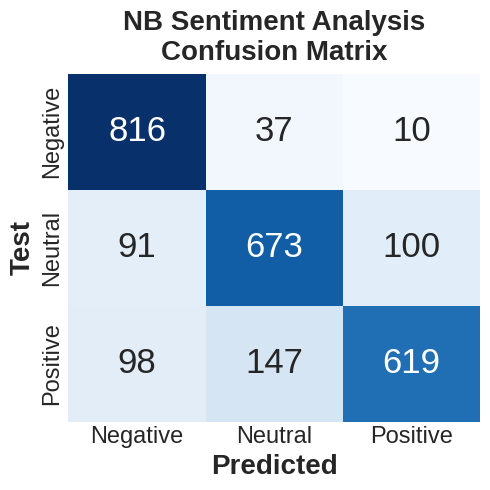

In [44]:
conf_matrix(y_test_le, nb_pred,'NB Sentiment Analysis\nConfusion Matrix')

In [45]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.81      0.95      0.87       863
     Neutral       0.79      0.78      0.78       864
    Positive       0.85      0.72      0.78       864

    accuracy                           0.81      2591
   macro avg       0.82      0.81      0.81      2591
weighted avg       0.82      0.81      0.81      2591



In [49]:
print('Accuracy for Naive Bayes: ', accuracy_score(y_test_le, nb_pred))

Accuracy for Naive Bayes:  0.8135854882284832


BERT

In [50]:
MAX_LEN=128

In [51]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [52]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [53]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [54]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [55]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [56]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
170/170 [==============================] - 151s 780ms/step - loss: 0.7225 - categorical_accuracy: 0.6679 - val_loss: 0.4407 - val_categorical_accuracy: 0.8231
Epoch 2/4
170/170 [==============================] - 133s 785ms/step - loss: 0.3279 - categorical_accuracy: 0.8796 - val_loss: 0.3278 - val_categorical_accuracy: 0.8793
Epoch 3/4
170/170 [==============================] - 135s 792ms/step - loss: 0.1950 - categorical_accuracy: 0.9325 - val_loss: 0.3118 - val_categorical_accuracy: 0.8876
Epoch 4/4
170/170 [==============================] - 140s 821ms/step - loss: 0.1192 - categorical_accuracy: 0.9641 - val_loss: 0.3355 - val_categorical_accuracy: 0.8909


In [57]:
result_bert = model.predict([test_input_ids,test_attention_masks])


81/81 [==============================] - 27s 269ms/step


In [58]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

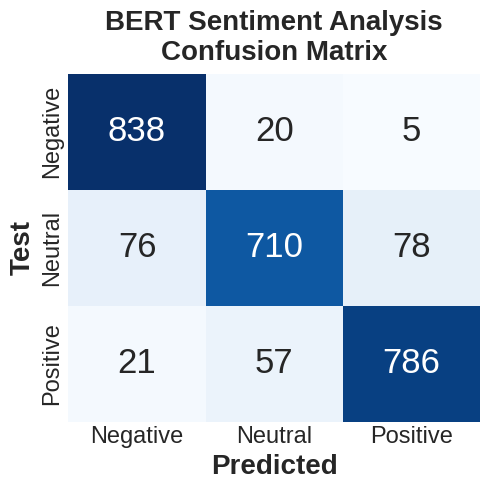

In [59]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')


In [60]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.90      0.97      0.93       863
     Neutral       0.90      0.82      0.86       864
    Positive       0.90      0.91      0.91       864

   micro avg       0.90      0.90      0.90      2591
   macro avg       0.90      0.90      0.90      2591
weighted avg       0.90      0.90      0.90      2591
 samples avg       0.90      0.90      0.90      2591



In [61]:
print('Accuracy for Naive Bayes: ', accuracy_score(y_test, y_pred_bert))

Accuracy for Naive Bayes:  0.9008104978772674


RoBERTa

In [62]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

In [63]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

73

In [64]:
MAX_LEN=128

In [65]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [66]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [70]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [71]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [72]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model_1 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['input_3[0][0]',             
 rtaModel)                   ngAndCrossAttentions(last_   32         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [73]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)


Epoch 1/4
182/182 [==============================] - 157s 740ms/step - loss: 0.6522 - categorical_accuracy: 0.7128 - val_loss: 0.3145 - val_categorical_accuracy: 0.8777
Epoch 2/4
182/182 [==============================] - 134s 738ms/step - loss: 0.2974 - categorical_accuracy: 0.8910 - val_loss: 0.2722 - val_categorical_accuracy: 0.8926
Epoch 3/4
182/182 [==============================] - 134s 739ms/step - loss: 0.1960 - categorical_accuracy: 0.9241 - val_loss: 0.2991 - val_categorical_accuracy: 0.8992
Epoch 4/4
182/182 [==============================] - 135s 740ms/step - loss: 0.1439 - categorical_accuracy: 0.9485 - val_loss: 0.2440 - val_categorical_accuracy: 0.9157


In [74]:
result_roberta = model.predict([test_input_ids,test_attention_masks])


81/81 [==============================] - 27s 260ms/step


In [75]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

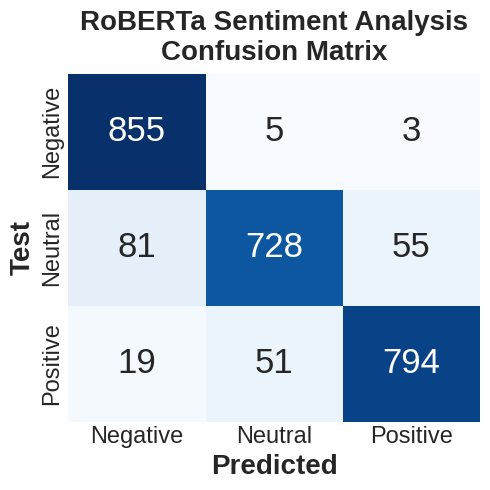

In [76]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [77]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.90      0.99      0.94       863
     Neutral       0.93      0.84      0.88       864
    Positive       0.93      0.92      0.93       864

   micro avg       0.92      0.92      0.92      2591
   macro avg       0.92      0.92      0.92      2591
weighted avg       0.92      0.92      0.92      2591
 samples avg       0.92      0.92      0.92      2591



In [78]:
print('Accuracy for Naive Bayes: ', accuracy_score(y_test, y_pred_roberta))

Accuracy for Naive Bayes:  0.9174064067927441


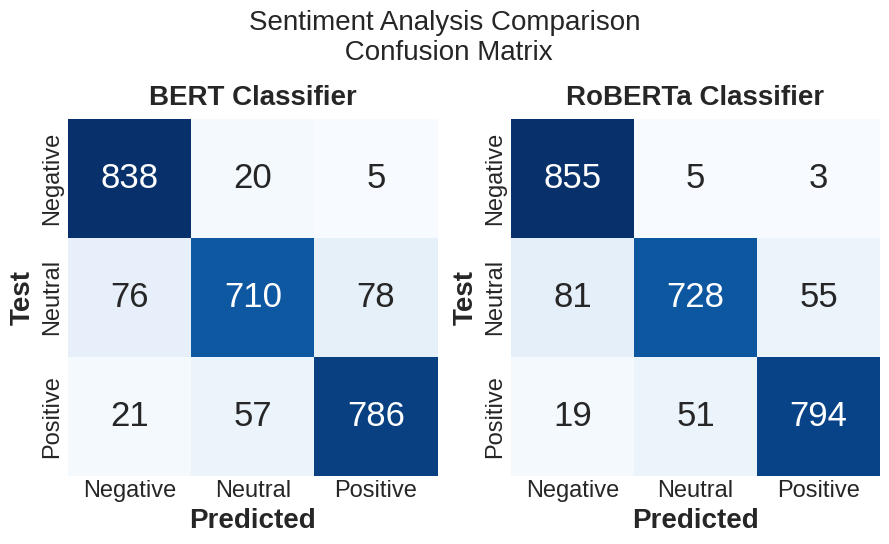

In [79]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()